In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
from scipy import stats
import statsmodels.api as sm

from numba import jit

import sys
sys.path.append('../shared')
from bartolozziSPEED import *

In [12]:
def p(k, i, xi, A, a, h, k2coord, Gt):
    return 1 / (1 + math.exp(-2 * I(k, i, xi, A, a, h, k2coord, Gt)))

def I(k, i, xi, A, a, h, k2coord, Gt):
    total = 0
    zeta = random.uniform(-1,1)  # sampled for each unique (k,i)
    for j in k2coord[k]:  # for each coordinate in cluster k
        eta = random.uniform(-1,1)  # different for each cell
        sigma = Gt[j]
        total += ((A*xi[k] + a*eta) * sigma) + h*zeta
    return (1 / len(k2coord[k])) * total

def cluster_info(arr):
    """ number of clusters (nonzero fields separated by 0s) in array
        and size of cluster
    """
    data = []
    k2coord = {}
    k = 0
    if arr[0] != 0: # left boundary
        data.append(0) # we will increment later in loop  
        k2coord[k] = []
    else:
        k=-1

    # print("arr", arr)
    # print("data", data)
    
    for i in range(0,len(arr)-1):
        if arr[i] == 0 and arr[i+1] != 0:
            data.append(0)
            k += 1
            k2coord[k] = []
        if arr[i] != 0:
            data[-1] += 1
            k2coord[k].append(i)
    if arr[-1] != 0:
        if data:  # if array is not empty
            data[-1] += 1  # right boundary
            k2coord[k].append(len(arr)-1)
        else:
            data.append(1)  
            k2coord[k] = [len(arr)-1]
            
    Ncl = len(data)  # number of clusters
    Nk = data  # Nk[k] = size of cluster k
    coord2k = {e:k for k,v in k2coord.items() for e in v}
    return Ncl, Nk, k2coord, coord2k

In [47]:
# pd = 0.25
# pe = 0.02
# ph = 0.18 # vary
pd = 0.1 # prob of leaving at edge
pe = 0.0001 # sponteanously emergin 
ph = 0.1 #getting non-active neighbour to join

pa = 0.5 #proportion of passive vs inactive 
        ## half/half distribution of selling vs buying

N0 = 2000
N1 = 200

A = 2 # 
a = 0.1 # 
h = 0.1 # 

G = np.zeros(shape=(N0,N1)).astype(int)
G[0] = np.random.choice(a=[-1,0,1], p=[pa/2, 1-pa, pa/2], size=N1, replace=True)

x = np.empty(N0)

for t in range(N0):
    Ncl, Nk, k2coord, coord2k = cluster_info(G[t])
    xi = np.random.uniform(-1, 1, size=Ncl)  # unique xi for each cluster k
    # print(Ncl, Nk, k2coord, coord2k, xi)

    xt = 0
    for k, size in enumerate(Nk):
        tmp = 0
        for i in k2coord[k]:
            tmp += G[t,i]
        xt += size * tmp
    x[t] = xt

    if t == N0-1:
        # last iteration, we stop
        break

    for i in range(N1):
        # traders update their stance
        if G[t,i] != 0:
            k = coord2k[i]
            # print(k)
            pp = p(k, i, xi, A, a, h, k2coord, G[t])
            if random.random() < pp:
                G[t+1,i] = 1
            else:
                G[t+1,i] = -1

        
        # trader influences non-active neighbour to join
        if G[t,i] != 0:
            stance = G[t,i]
            if random.random() < ph:
                if G[t,(i-1)%N1] == 0 and G[t,(i+1)%N1] == 0:
                    ni = random.choice([-1,1])
                    G[t+1,(i+ni)%N1] = stance#random.choice([-1,1])
                elif G[t,(i-1)%N1] == 0:
                    G[t+1,(i-1)%N1] = stance#random.choice([-1,1])
                elif G[t,(i+1)%N1] == 0:
                    G[t+1,(i+1)%N1] = stance#random.choice([-1,1])
                else:
                    continue

        # active trader diffuses if it has inactive neighbour
        # only happens at edge of cluster
        if G[t,i] != 0:
            if random.random() < pd:
                if (G[t,(i-1)%N1] == 0) or (G[t,(i+1)%N1] == 0):
                    G[t+1,i] = 0
                else:
                    continue

        # nontrader enters market
        if G[t,i] == 0:
            if random.random() < pe:
                G[t+1,i] = random.choice([-1,1])

[   66.   -22.     6. ...  -295.  2469. -1267.]


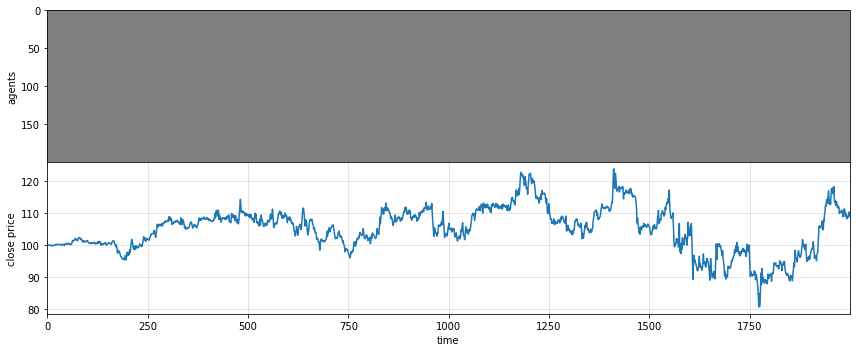

In [57]:
fig, (ax1, ax2) = plt.subplots(
    ncols=1, nrows=2, figsize=(12,5), sharex=True, gridspec_kw = {'wspace':0, 'hspace':0}
)
ax1.imshow(G.T, cmap="binary", interpolation="None", aspect="auto")
# plt.colorbar()

r = (x - np.mean(x)) / np.std(x)
s = 100
S = np.zeros_like(x)
S[0] = s
for i in range(1,N0):
    # S[i] = S[i-1] + (S[i-1] * r[i])
    S[i] = S[i-1] + (S[i-1] * r[i]/100) + 0.01

ax2.plot(S)
ax2.grid(alpha=0.4)
ax2.set_xlabel("time")
# ax2.set_ylabel("standardised log returns")
ax2.set_ylabel("close price")
ax1.set_ylabel("agents")
plt.tight_layout()
plt.show()

In [49]:
count = int(x.shape[0] / 500)
rel_var = np.zeros(count)

print(x)

for i in range(count):
    rel_var[i] = np.sum(x[i * 500: (i+1) * 500]**2)

print(rel_var)

# r = (x - np.mean(x)) / np.std(x)
# s = 100
# S = np.zeros_like(x)
# S[0] = s
# for i in range(1,N0):
#     # S[i] = S[i-1] + (S[i-1] * r[i])
#     S[i] = S[i-1] + (S[i-1] * r[i]/100) + 0.01

[   66.   -22.     6. ...  -295.  2469. -1267.]
[3.56151625e+08 8.58290392e+08 9.65996935e+08 3.13525199e+09]


In [50]:
count = int(r.shape[0] / 500)
rel_var = np.zeros(count)

print(r)

for i in range(count):
    rel_var[i] = np.sum(r[i * 500: (i+1) * 500]**2)

print(rel_var)

# r = (x - np.mean(x)) / np.std(x)
# s = 100
# S = np.zeros_like(x)
# S[0] = s
# for i in range(1,N0):
#     # S[i] = S[i-1] + (S[i-1] * r[i])
#     S[i] = S[i-1] + (S[i-1] * r[i]/100) + 0.01

[ 0.02776786 -0.02621463 -0.00903839 ... -0.19368305  1.50185797
 -0.78994422]
[ 133.81348833  323.07279673  363.4793161  1179.63439884]


In [52]:
## rel_vol without chunking 
print(np.sum(r**2))

1999.9999999999998


In [97]:
## lets parameterise the function 
def execute(pd, pe, ph, A, a, h):
    pa = 0.5
    N0 = 5000
    N1 = 200

    G = np.zeros(shape=(N0,N1)).astype(int)
    G[0] = np.random.choice(a=[-1,0,1], p=[pa/2, 1-pa, pa/2], size=N1, replace=True)

    x = np.empty(N0)

    for t in range(N0):
        Ncl, Nk, k2coord, coord2k = cluster_info(G[t])
        xi = np.random.uniform(-1, 1, size=Ncl)  # unique xi for each cluster k
        # print(Ncl, Nk, k2coord, coord2k, xi)

        xt = 0
        for k, size in enumerate(Nk):
            tmp = 0
            for i in k2coord[k]:
                tmp += G[t,i]
            xt += size * tmp
        x[t] = xt

        if t == N0-1:
            # last iteration, we stop
            break

        for i in range(N1):
            # traders update their stance
            if G[t,i] != 0:
                k = coord2k[i]
                # print(k)
                pp = p(k, i, xi, A, a, h, k2coord, G[t])
                if random.random() < pp:
                    G[t+1,i] = 1
                else:
                    G[t+1,i] = -1

            
            # trader influences non-active neighbour to join
            if G[t,i] != 0:
                stance = G[t,i]
                if random.random() < ph:
                    if G[t,(i-1)%N1] == 0 and G[t,(i+1)%N1] == 0:
                        ni = random.choice([-1,1])
                        G[t+1,(i+ni)%N1] = stance#random.choice([-1,1])
                    elif G[t,(i-1)%N1] == 0:
                        G[t+1,(i-1)%N1] = stance#random.choice([-1,1])
                    elif G[t,(i+1)%N1] == 0:
                        G[t+1,(i+1)%N1] = stance#random.choice([-1,1])
                    else:
                        continue
                
            # active trader diffuses if it has inactive neighbour
            # only happens at edge of cluster
            if G[t,i] != 0:
                if random.random() < pd:
                    if (G[t,(i-1)%N1] == 0) or (G[t,(i+1)%N1] == 0):
                        G[t+1,i] = 0
                    else:
                        continue

            # nontrader enters market
            if G[t,i] == 0:
                if random.random() < pe:
                    G[t+1,i] = random.choice([-1,1])

    ## r = (x - np.mean(x)) / np.std(x)

    return x, G

In [5]:
r, G = execute(0.1, 0.0001, 0.1, 2, 0.1, 0.1)
print(r)
print(np.sum(r**2))

[   29.    37.    95. ... -2201.  2343. -2627.]
15945939831.0


In [67]:
a_vals = np.linspace(0, 1, 10)
res_a = np.zeros(a_vals.shape[0])

for i, val in enumerate(a_vals):
    x, G = execute(0.1, 0.0001, 0.1, 2, val, 0.1)
    res_a[i] = np.sum(x**2)

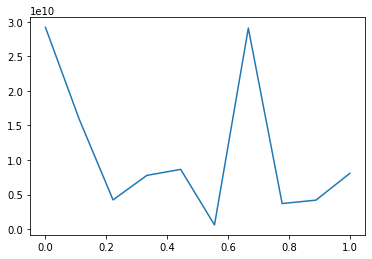

In [68]:
plt.plot(a_vals, res_a)

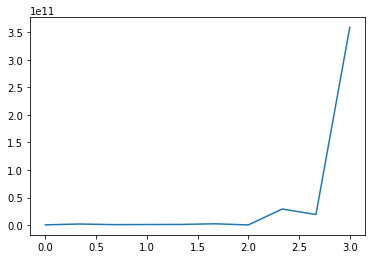

In [70]:
A_vals = np.linspace(0, 3, 10)
res_A = np.zeros(A_vals.shape[0])

for i, val in enumerate(A_vals):
    x, G = execute(0.1, 0.0001, 0.1, val, 0.1, 0.1)
    res_A[i] = np.sum(x**2)

plt.plot(A_vals, res_A)


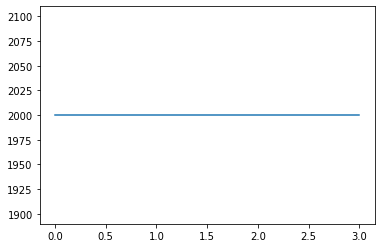

In [73]:
A_vals = np.linspace(0, 3, 10)
res_A = np.zeros(A_vals.shape[0])

for i, val in enumerate(A_vals):
    x, G = execute(0.1, 0.0001, 0.1, val, 0.1, 0.1)
    r = (x - np.mean(x)) / np.std(x)
    res_A[i] = np.sum(r**2)

plt.plot(A_vals, res_A)

In [7]:
x, G = execute(0.1, 0.0001, 0.1, 2, 0.1, 0.1)
r = (x - np.mean(x)) / np.std(x)
print(np.min(r), np.max(r))

-3.544614377406645 3.505483411750707


In [8]:
df = pd.read_csv("../../data/all_world_indices_clean.csv")
df_spx = df[["Date", "SPX Index"]]
df_spx["Date"] = pd.to_datetime(df_spx["Date"], format='%d/%m/%Y')
df_spx = df_spx.sort_values(by="Date")
df_spx.reset_index(inplace=True)
series_array = np.array(df_spx["SPX Index"])

/home/james/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
log_ret_dat = np.diff(np.log(series_array))
log_ret_dat_stan = (log_ret_dat - np.mean(log_ret_dat)) / np.std(log_ret_dat)
print(np.min(log_ret_dat_stan), np.max(log_ret_dat_stan))

-10.240801383102127 8.372469411181111


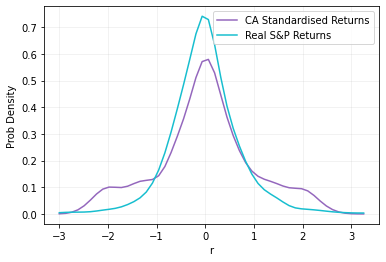

In [135]:
x_eval = np.linspace(-3, 3.25, 50)

kde1 = stats.gaussian_kde(r)
plt.plot(x_eval, kde1(x_eval), color="C4", label="CA Standardised Returns")

kde2 = stats.gaussian_kde(log_ret_dat_stan)
plt.plot(x_eval, kde2(x_eval), color="C9", label="Real S&P Returns")

plt.grid(alpha=0.2)
plt.legend()
plt.xlabel("r")
plt.ylabel("Prob Density")
plt.savefig("imgs/dist_vs")
plt.show()

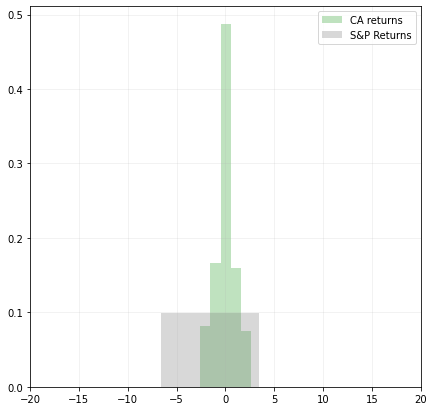

In [134]:
fig = plt.figure(figsize=(7, 7))
plt.hist(r, alpha=0.3, color="C2", bins=5, density=True, label="CA returns")
plt.hist(log_ret_dat_stan, alpha=0.3, color="C7", bins=5, density=True, label="S&P Returns")
plt.grid(alpha=0.2)
plt.legend()
plt.xlim(-20, 20)
plt.show()

(0.0, 100.0)

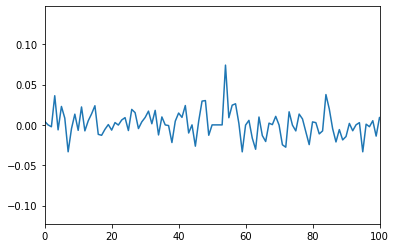

In [147]:
plt.plot(log_ret_dat[1:])

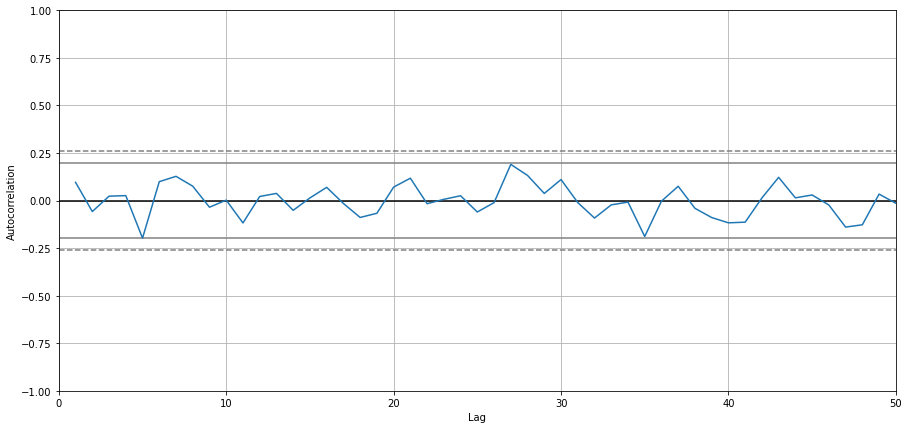

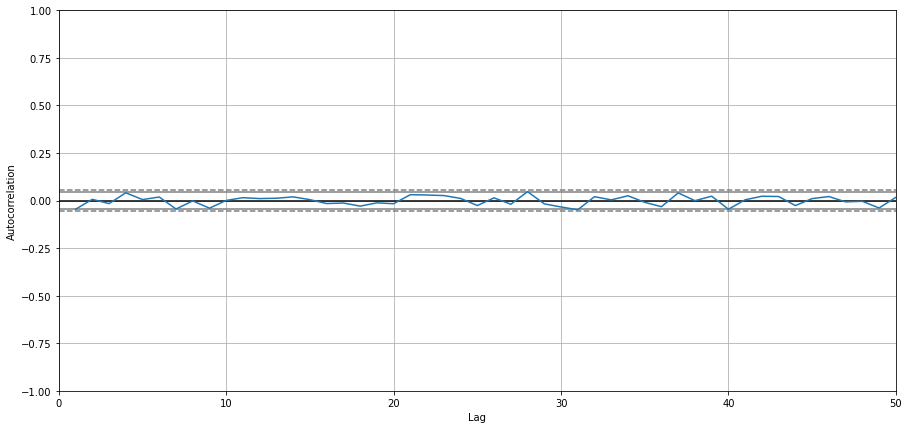

In [159]:
## autocorrlation plot
plt.figure(figsize=(15, 7))
pd.plotting.autocorrelation_plot(log_ret_dat_stan[1:100])
plt.xlim(0, 50)
plt.show()

## autocorrlation plot
plt.figure(figsize=(15, 7))
pd.plotting.autocorrelation_plot(x)
plt.xlim(0, 50)
plt.show()

## this is fucked we want lag=0 also

<Figure size 504x504 with 0 Axes>

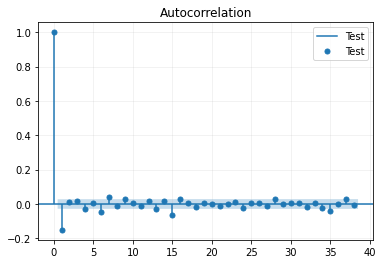

In [211]:
# sm.graphics.tsa.plot_acf(log_ret_dat_stan[1:])
# plt.legend()
# plt.show()
fig = plt.figure(figsize=(7, 7))
sm.graphics.tsa.plot_acf(log_ret_dat_stan[1:], label="Test")
handles, labels= ax1.get_legend_handles_labels()
plt.grid(alpha=0.2)
plt.legend()
plt.show()

/home/james/.local/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/home/james/.local/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


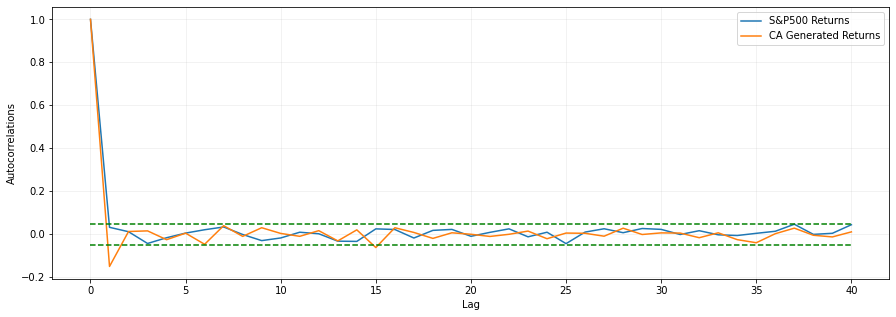

In [241]:
acf_x = sm.tsa.stattools.acf(r)
acf_sp = sm.tsa.stattools.acf(log_ret_dat_stan[1:])

x = np.arange(acf.shape[0])

## intervals placed at 2 standard errors around mean
## https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html
x_sem = 2*stats.sem(acf_x)

fig = plt.figure(figsize=(15, 5))
plt.plot(x, acf_x, label="S&P500 Returns")
plt.plot(x, acf_sp, label="CA Generated Returns")
plt.plot(x, [x_sem]*acf.shape[0], "--", color="green")
plt.plot(x, [-1 * x_sem]*acf.shape[0], "--", color="green")
plt.xlabel("Lag")
plt.ylabel("Autocorrelations")
plt.grid(alpha=0.2)
plt.legend()
plt.savefig("imgs/acf_ret")
plt.show()

In [62]:
x, G = execute(0.1, 0.0001, 0.0493, 1.8, 0.1, 0)
print(x.shape[0])
r = (x - np.mean(x)) / np.std(x)
r = (x - np.mean(x)) / np.std(x)
s = 100
S = np.zeros_like(x)
S[0] = s
for i in range(1,N0):
    # S[i] = S[i-1] + (S[i-1] * r[i])
    S[i] = S[i-1] + (S[i-1] * r[i]/100) + 0.01

4000


NameError: name 'N0' is not defined

In [ ]:
log_ret_dat = np.diff(np.log(series_array))
log_ret_dat_stan = (log_ret_dat - np.mean(log_ret_dat)) / np.std(log_ret_dat)

In [263]:
print(r.shape[0])
print(log_ret_dat[:41].shape[0])

2000
41


/home/james/.local/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/home/james/.local/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


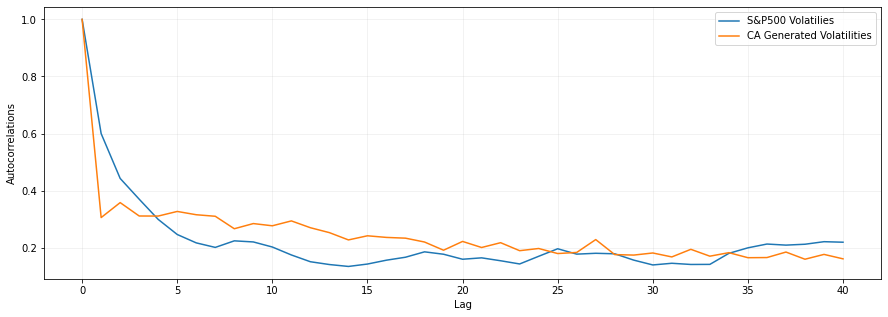

In [268]:
## now do the absolute volatility
x_vol = np.abs(r)
dat_vol = np.abs(log_ret_dat)

acf_x_vol = sm.tsa.stattools.acf(x_vol)
acf_sp_vol = sm.tsa.stattools.acf(dat_vol)

x = np.arange(acf_x_vol.shape[0])

## intervals placed at 2 standard errors around mean
## https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html
x_sem = 2*stats.sem(acf_x_vol)

mean_sp = np.mean(acf_sp_vol)
fig = plt.figure(figsize=(15, 5))
plt.plot(x, acf_x_vol, label="S&P500 Volatilies")
plt.plot(x, acf_sp_vol, label="CA Generated Volatilities")
##plt.plot(x, np.mean(acf_x_vol) + [x_sem]*acf_sp_vol.shape[0], "--", color="green")
##plt.plot(x, np.mean(acf_x_vol) - [x_sem]*acf_sp_vol.shape[0], "--", color="green")
plt.xlabel("Lag")
plt.ylabel("Autocorrelations")
plt.grid(alpha=0.2)
plt.legend()
plt.savefig("imgs/acf_vol")
plt.show()

In [2]:
@jit(nopython=True)
def genhurst(S,q):

    start = 50
    stop = 700

    L=len(S)       
       
    H = np.zeros((len(range(start,stop)),1))
    k = 0
    
    for Tmax in range(start, stop):
        
        x = np.arange(1,Tmax+1,1)
        mcord = np.zeros((Tmax,1))
        
        for tt in range(1,Tmax+1):
            dV = S[np.arange(tt,L,tt)] - S[np.arange(tt,L,tt)-tt] 
            VV = S[np.arange(tt,L+tt,tt)-tt]
            N = len(dV) + 1
            X = np.arange(1,N+1,dtype=np.float64)
            Y = VV
            mx = np.sum(X)/N
            SSxx = np.sum(X**2) - N*mx**2
            my = np.sum(Y)/N
            SSxy = np.sum( np.multiply(X,Y))  - N*mx*my
            cc1 = SSxy/SSxx
            cc2 = my - cc1*mx
            ddVd = dV - cc1
            VVVd = VV - np.multiply(cc1,np.arange(1,N+1,dtype=np.float64)) - cc2
            mcord[tt-1] = np.mean( np.abs(ddVd)**q )/np.mean( np.abs(VVVd)**q )
            
        mx = np.mean(np.log10(x))
        SSxx = np.sum( np.log10(x)**2) - Tmax*mx**2
        my = np.mean(np.log10(mcord))
        SSxy = np.sum( np.multiply(np.log10(x),np.transpose(np.log10(mcord)))) - Tmax*mx*my
        H[k] = SSxy/SSxx
        k = k + 1
        
    mH = np.mean(H)/q
    
    return mH

In [111]:
x, G = execute(pd=0.1, pe=0.0001, ph=0.0493, A=1.8, a=0.1, h=0)
r = (x - np.mean(x)) / np.std(x)

s = 1461
S = np.zeros_like(x)
S[0] = s
for i in range(1, 5000):
    S[i] = S[i-1] + (S[i-1] * r[i]/100) + 0.01

q_vals = np.linspace(1, 5, 21)
h_res = np.zeros(q_vals.shape[0])

for i, val in enumerate(q_vals):
    h_res[i] = genhurst(S, val)

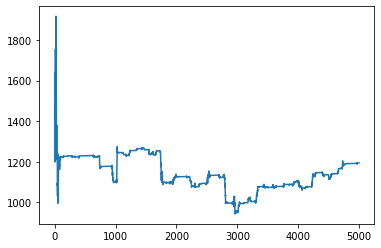

In [112]:
plt.plot(S)

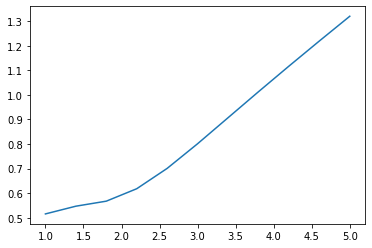

In [104]:
plt.plot(q_vals, np.multiply(q_vals, h_res))

In [91]:
df = pd.read_csv("../../data/all_world_indices_clean.csv")
df_spx = df[["Date", "SPX Index"]]
df_spx["Date"] = pd.to_datetime(df_spx["Date"], format='%d/%m/%Y')
df_spx = df_spx.sort_values(by="Date")
df_spx.reset_index(inplace=True)
series_array = np.array(df_spx["SPX Index"])

q_vals = np.linspace(1, 5, 21)
h_res = np.zeros(q_vals.shape[0])

for i, val in enumerate(q_vals):
    h_res[i] = genhurst(series_array, val)

/home/james/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


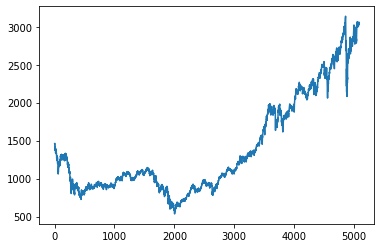

In [109]:
plt.plot(series_array)

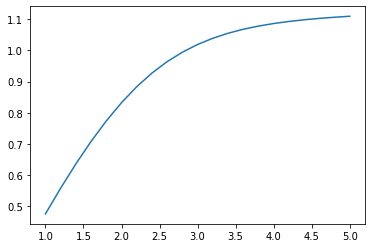

In [92]:
plt.plot(q_vals, q_vals*h_res)

In [2]:

A = 1.8
pd = 0.1  # probability that an active trader diffuses and becomes inactive
pe = 0.0001 # probability that a nontrading enters the market
ph = 0.0493 # probability that an active trader can turn one of his inactive neighbors into an active one
pa = 0.5 # active and inactive distribution 

N0 = 5000 # timepoints
N1 = 200  # granulization of the grid / agents

a = 0.1 # randomness of A 
h = 0  # external field reflecting the effects of the environmnet

G, RVAR_ARRAY = generate(pd, pe, ph, pa, N0, N1, A, a, h)
r = (RVAR_ARRAY - np.mean(RVAR_ARRAY)) / np.std(RVAR_ARRAY)

s = 100
S = np.zeros_like(RVAR_ARRAY)
S[0] = s
for i in range(1, 5000):
    S[i] = S[i-1] + (S[i-1] * RVAR_ARRAY[i]/1000)

# q_vals = np.linspace(1, 5, 21)
# h_res = np.zeros(q_vals.shape[0])

# for i, val in enumerate(q_vals):
#     h_res[i] = genhurst(S, val)

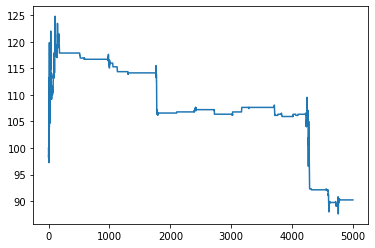

In [8]:
plt.plot(S)

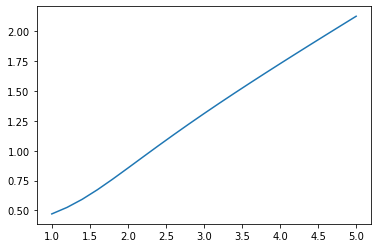

In [120]:
plt.plot(q_vals, q_vals*h_res)

In [42]:
def get_hurst_exponent(time_series, max_lag=200):
    """Returns the Hurst Exponent of the time series"""
    
    lags = range(2, max_lag)
    q_vals = np.linspace(1, 5, 30) 
    S_q = np.zeros(len(lags))
    reg = np.zeros(len(q_vals))
    for i, q_val in enumerate(q_vals):
        for j, lag in enumerate(lags):
            S_q[j] = np.mean(np.abs(time_series[lag:]-time_series[:-lag])**q_val)
         # calculate the slope of the log plot -> the Hurst Exponent
        reg[i] = np.polyfit(np.log(lags), np.log(S_q), 1)[0]

    return reg/q_vals, q_vals

In [29]:
df = pd.read_csv("../../data/all_world_indices_clean.csv")
df_spx = df[["Date", "SPX Index"]]
df_spx["Date"] = pd.to_datetime(df_spx["Date"], format='%d/%m/%Y')
df_spx = df_spx.sort_values(by="Date")
df_spx.reset_index(inplace=True)
series_array = np.array(df_spx["SPX Index"])

h_res, q_vals = get_hurst_exponent(series_array)
print(h_res)

/home/james/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
[0.491458   0.48572968 0.47936635 0.47230806 0.4645065  0.45593112
 0.44657506 0.43645992 0.42563825 0.41419308 0.40223418 0.38989125
 0.37730535 0.36461957 0.35197069 0.33948237 0.32726078 0.31539239
 0.30394366 0.29296222 0.28247892 0.27251029 0.26306116 0.25412716
 0.24569687 0.23775384 0.23027806 0.22324732 0.21663817 0.21042667]


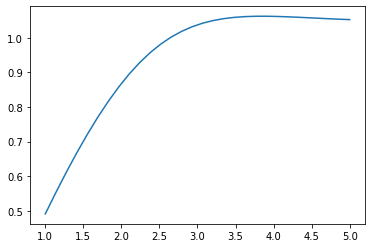

In [30]:
plt.plot(q_vals, q_vals*h_res)

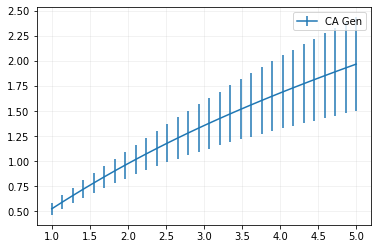

In [77]:
A = 1.8
pd = 0.05  # probability that an active trader diffuses and becomes inactive
pe = 0.0001 # probability that a nontrading enters the market
ph = 0.0493 # probability that an active trader can turn one of his inactive neighbors into an active one
pa = 0.5 # active and inactive distribution 

N0 = 5000 # timepoints
N1 = 200  # granulization of the grid / agents

a = 3.6 # randomness of A 
h = 0  # external field reflecting the effects of the environmnet

res = np.zeros((20, 30))

for z in range(20):
    G, x = generate(pd, pe, ph, pa, N0, N1, A, a, h)
    r = (x - np.mean(x)) / np.std(x)

    s = 1461
    S = np.zeros_like(x)
    S[0] = s
    for i in range(1, 5000):
        S[i] = S[i-1] + (S[i-1] * r[i]/100) + 0.01

    h_res, q_vals = get_hurst_exponent(S)
    res[z,:] = h_res*q_vals

res_mean_ca = np.mean(res, axis=0)
res_std_ca = np.std(res, axis=0)

plt.errorbar(q_vals, res_mean, yerr=res_std, label='CA Gen')
plt.grid(alpha=0.2)
plt.legend()
plt.savefig("imgs/hurts_exponent")

/home/james/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


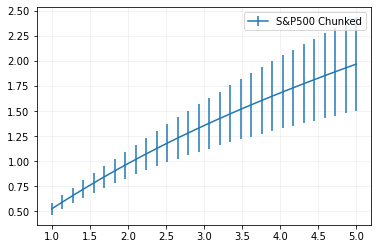

In [91]:
df = pd.read_csv("../../data/all_world_indices_clean.csv")
df_spx = df[["Date", "SPX Index"]]
df_spx["Date"] = pd.to_datetime(df_spx["Date"], format='%d/%m/%Y')
df_spx = df_spx.sort_values(by="Date")
df_spx.reset_index(inplace=True)
series_array = np.array(df_spx["SPX Index"])

## identical to np.split but doesnt raise exception if arrays not equal length
split = np.array_split(series_array, 6)
res = np.zeros((6, 30))

for i in range(len(split)):
    h_res, q_vals = get_hurst_exponent(split[i])
    res[i,:] = h_res*q_vals

res_mean_sp = np.mean(res, axis=0)
res_std_sp = np.std(res, axis=0)

plt.errorbar(q_vals, res_mean, yerr=res_std, label='S&P500 Chunked')
plt.grid(alpha=0.2)
plt.legend()
plt.savefig("imgs/hurts_exponent")

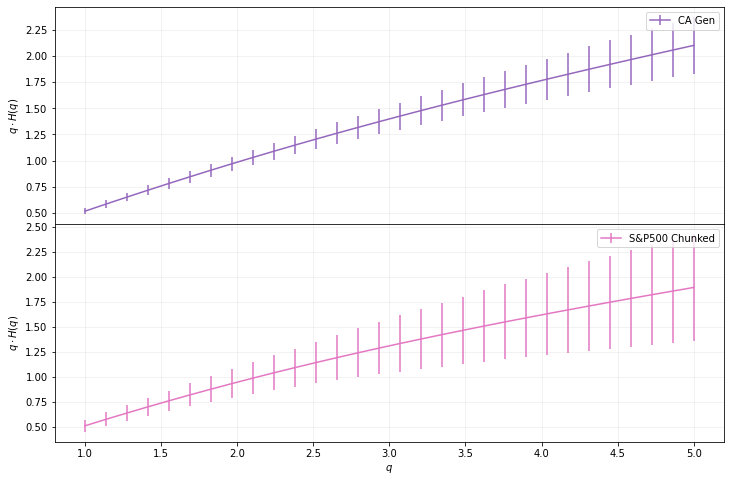

In [94]:
fig, (ax1,ax2) = plt.subplots(
    ncols=1, nrows=2, figsize=(12,8), sharex=True, gridspec_kw = {'wspace':0, 'hspace':0}
)

ax1.errorbar(q_vals, res_mean_ca, color="C4", yerr=res_std_ca, label='CA Gen')
ax1.grid(alpha=0.2)
ax1.set_ylabel(r"$q \cdot H(q)$")
ax1.set_xlabel(r"$q$")
ax1.legend()

ax2.errorbar(q_vals, res_mean_sp, color="C6", yerr=res_std_sp, label='S&P500 Chunked')
ax2.grid(alpha=0.2)
ax2.set_ylabel(r"$q \cdot H(q)$")
ax2.set_xlabel(r"$q$")
plt.legend()
plt.savefig("imgs/img_hurst_exp_double")

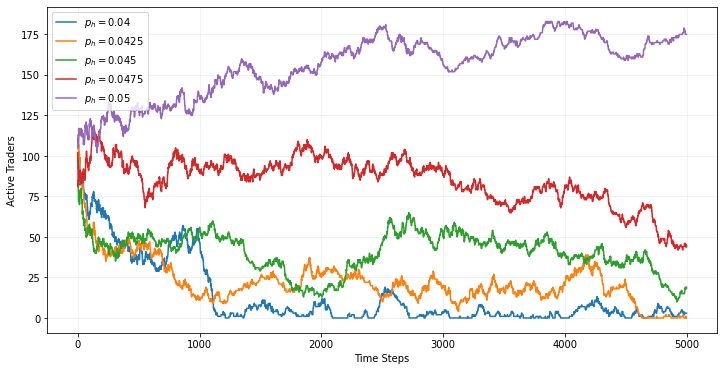

In [119]:
## extract the number of active traders from the grid 
A = 1.8
pd = 0.05  # probability that an active trader diffuses and becomes inactive
pe = 0.0001 # probability that a nontrading enters the market
pa = 0.5 # active and inactive distribution 

N0 = 5000 # timepoints
N1 = 200  # granulization of the grid / agents

a = 3.6 # randomness of A 
h = 0  # external field reflecting the effects of the environmnet

p_h_vals = np.linspace(0.04, 0.05, 5)

fig = plt.figure(figsize=(12, 6))
for i, val in enumerate(p_h_vals):
    G, x = generate(pd, pe, val, pa, N0, N1, A, a, h)
    G = G.T
    G = np.where(((G == -1) | (G==1)), 1, 0)
    active_t = np.sum(G, axis=0)
    plt.plot(active_t, label=r"$p_h = {{{}}}$".format(val))
plt.ylabel("Active Traders")
plt.xlabel("Time Steps")
plt.grid(alpha=0.2)
plt.legend()
plt.savefig("imgs/figure1a")
plt.show()

In [102]:
print(G)
print(G.shape)


# 1 is buy
# -1 sell
# 0 is inactive

## active traders in each time step


[[0 0 0 ... 1 0 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 1 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(5000, 200)
(5000,)
